In [1]:
import numpy as np
import pandas as pd
from sklearn.kernel_approximation import RBFSampler

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)

In [2]:
def date_range(duration, fs, start=0):
    """ 
    Parameters:
        duration: length
        fs: sampling frequency
        start: Start iimestamp 
    Returns: DatetimeIndex
    """
    return pd.to_datetime(
        np.linspace(0, 1e9*duration, num=fs*duration, endpoint=False),
        unit='ns',
        origin=start)

def simulate_data(mode='jump_up'):
    rng = date_range(400, 1)
    if mode == 'jump_up':
        before = np.random.normal(20, 1, 200)
        after = np.random.normal(20, 1, 100)
        occupant = np.random.normal(25, 1, 100)
        dat = pd.DataFrame({'time':rng, 'value':np.r_[before, occupant, after]})
    elif mode == 'slow_trend':
        raise NotImplementedError
    elif mode == 'spike_noise':
        raise NotImplementedError
        
    return dat

In [3]:
jump_up = simulate_data()

In [4]:
jump_up.head(2)

,time,value
0,1970-01-01 00:00:00,20.541989
1,1970-01-01 00:00:01,19.248607


Text(0.5,1,'Jump up pattern')

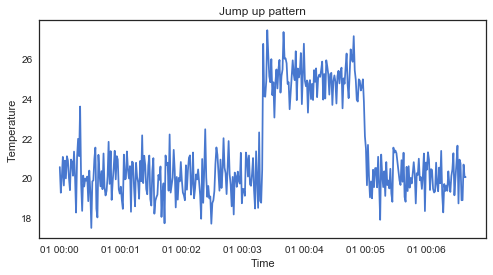

In [5]:
# visualize pattern
plt.figure(figsize=(8,4))
plt.plot(jump_up["time"], jump_up["value"])
plt.ylabel('Temperature')
plt.xlabel('Time')
plt.title("Jump up pattern")

In [6]:
class EXPoSE(object):
    """ Implementation of The EXPoSE (EXPected Similarity Estimation) algorithm 
    proposed by M. Schneider, W. Ertel and F. Ramos, "Expected Similarity 
    Estimation for Lage-Scale Batch and Streaming Anomaly Detection".
    """
    def __init__(self, decay_rate=.01, time_step=0,
                 headers=["time", "value", "anomaly_score"]):
        self.decay_rate = decay_rate
        self.time_step = time_step
        self.headers = headers
        self.kernel = None
        self.historical_model = []
    
    
    def set_kernel(self, gamma=.5, n_components=20000, random_state=10):
        """ Setup RBF sampler for the detector"""
        self.kernel = RBFSampler(gamma=gamma, n_components=n_components, random_state=random_state)
    
    
    def run(self, data):
        """ Run online algorithm with cold start
        """
        rows = []
        for i, row in data.iterrows():
            input_data = row.to_dict()
            detector_values = self.analyze(input_data)
            output_row = list(row) + list(detector_values)
            rows.append(output_row)
        results = pd.DataFrame(rows, columns=self.headers)
        return results

    
    def analyze(self, input_data):
        """ Returns anomalyScore list """
        # approximate feature map of a RBF kernel by using Random Kitchen 
        # Sinks approximation
        feature = self.kernel.fit_transform(np.array([[input_data["value"]]]))
        # calculate model as a weighted sum of new data point's feature
        # map and previous data points' kernel embedding
        if self.time_step == 0:
            model = feature
        else:
            model = ((self.decay_rate * feature) + (1 - self.decay_rate) *
                     self.historical_model)
        # Update previous expose model
        self.historical_model = model
        # Caculate similarity measure
        anomaly_score = np.asscalar(1 - np.inner(feature, model))
        self.time_step += 1

        return [anomaly_score]

In [7]:
detector = EXPoSE()
# tune parameter for better performance
detector.set_kernel()

In [8]:
result = detector.run(jump_up)
# result.to_csv('result.csv')

Text(0.5,1,'Jump up pattern')

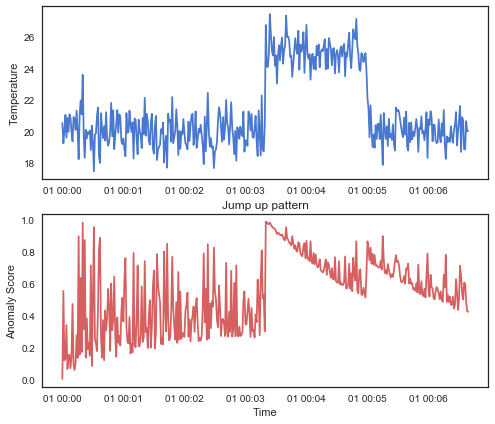

In [10]:
#visualize anomaly scores
plt.figure(figsize=(8,7))
plt.figure(1)
plt.subplot(211)
plt.plot(result["time"], result["value"], 'b')
plt.ylabel('Temperature')
plt.subplot(212)
plt.plot(result["time"], result["anomaly_score"], 'r')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.title("Jump up pattern")